# Team Project:B02-Hospital-Costs-and-Patient-Satisfaction
**Course:** BA775 Business Analytics Toolbox  
**Team Members:**  Yangze Li, Tae Yoon Kim, Shengqi Wei, Pin-Chu Yin, Michael Allieri  
**Instructor:** Professor Mohammad Soltanieh Ha  
**Objective:** Analyze the relationship between hospital costs and patient satisfaction across years using BigQuery.

# Problem Definition
This project aims to help hospital administrators, policymakers, and insurance payers understand how spending and patient experience relate across U.S. hospitals. By analyzing the relationship between hospital costs and patient satisfaction, we can identify whether higher spending actually translates into better outcomes and which regions or hospitals deliver the best value. The goal is to uncover patterns that support more efficient healthcare resource allocation and highlight potential performance gaps across states or hospital systems. Success is defined as producing clear, SQL-based evidence that reveals meaningful differences in cost, satisfaction, and value across hospitals.

# Introduction & Motivation
Hospitals in the U.S. are getting more expensive every year, but patients aren’t necessarily feeling more satisfied. So the real question is: are we paying for better care, or just paying more?
Our analysis looks at nationwide hospital cost and satisfaction data to find out whether higher spending actually leads to better patient experiences, and which states or hospitals deliver the best value for the money. This matters for hospital leaders, policymakers, and insurers who want to understand where money is being used effectively—and where it isn’t.

# Data Source

“Centers for Medicare & Medicaid Services Data.”

[https://data.cms.gov/provider-summary-by-type-of-service/medicare-inpatient-hospitals/medicare-inpatient-hospitals-by-provider-and-service](https://data.cms.gov/provider-summary-by-type-of-service/medicare-inpatient-hospitals/medicare-inpatient-hospitals-by-provider-and-service)

‌ “Medicare & Medicaid Hospital Quality Data ZIP Download Free | Open Data Marketplace.” Opendatabay.com, 2016,
[https://www.opendatabay.com/data/healthcare/b235f1d0-0a4f-4d02-87a2-2f92f002e009](https://www.opendatabay.com/data/healthcare/b235f1d0-0a4f-4d02-87a2-2f92f002e009).  Accessed 28 Oct. 2025.

**Data size:**

The dataset contains five CSV files (2016–2020) with approximately 1.14 GB total size. Each file includes around 200,000–250,000 rows and 30–40 columns, covering hospital IDs, patient responses, star ratings, and survey metrics across U.S. hospitals.

# Entity Relationship Diagram (ERD):

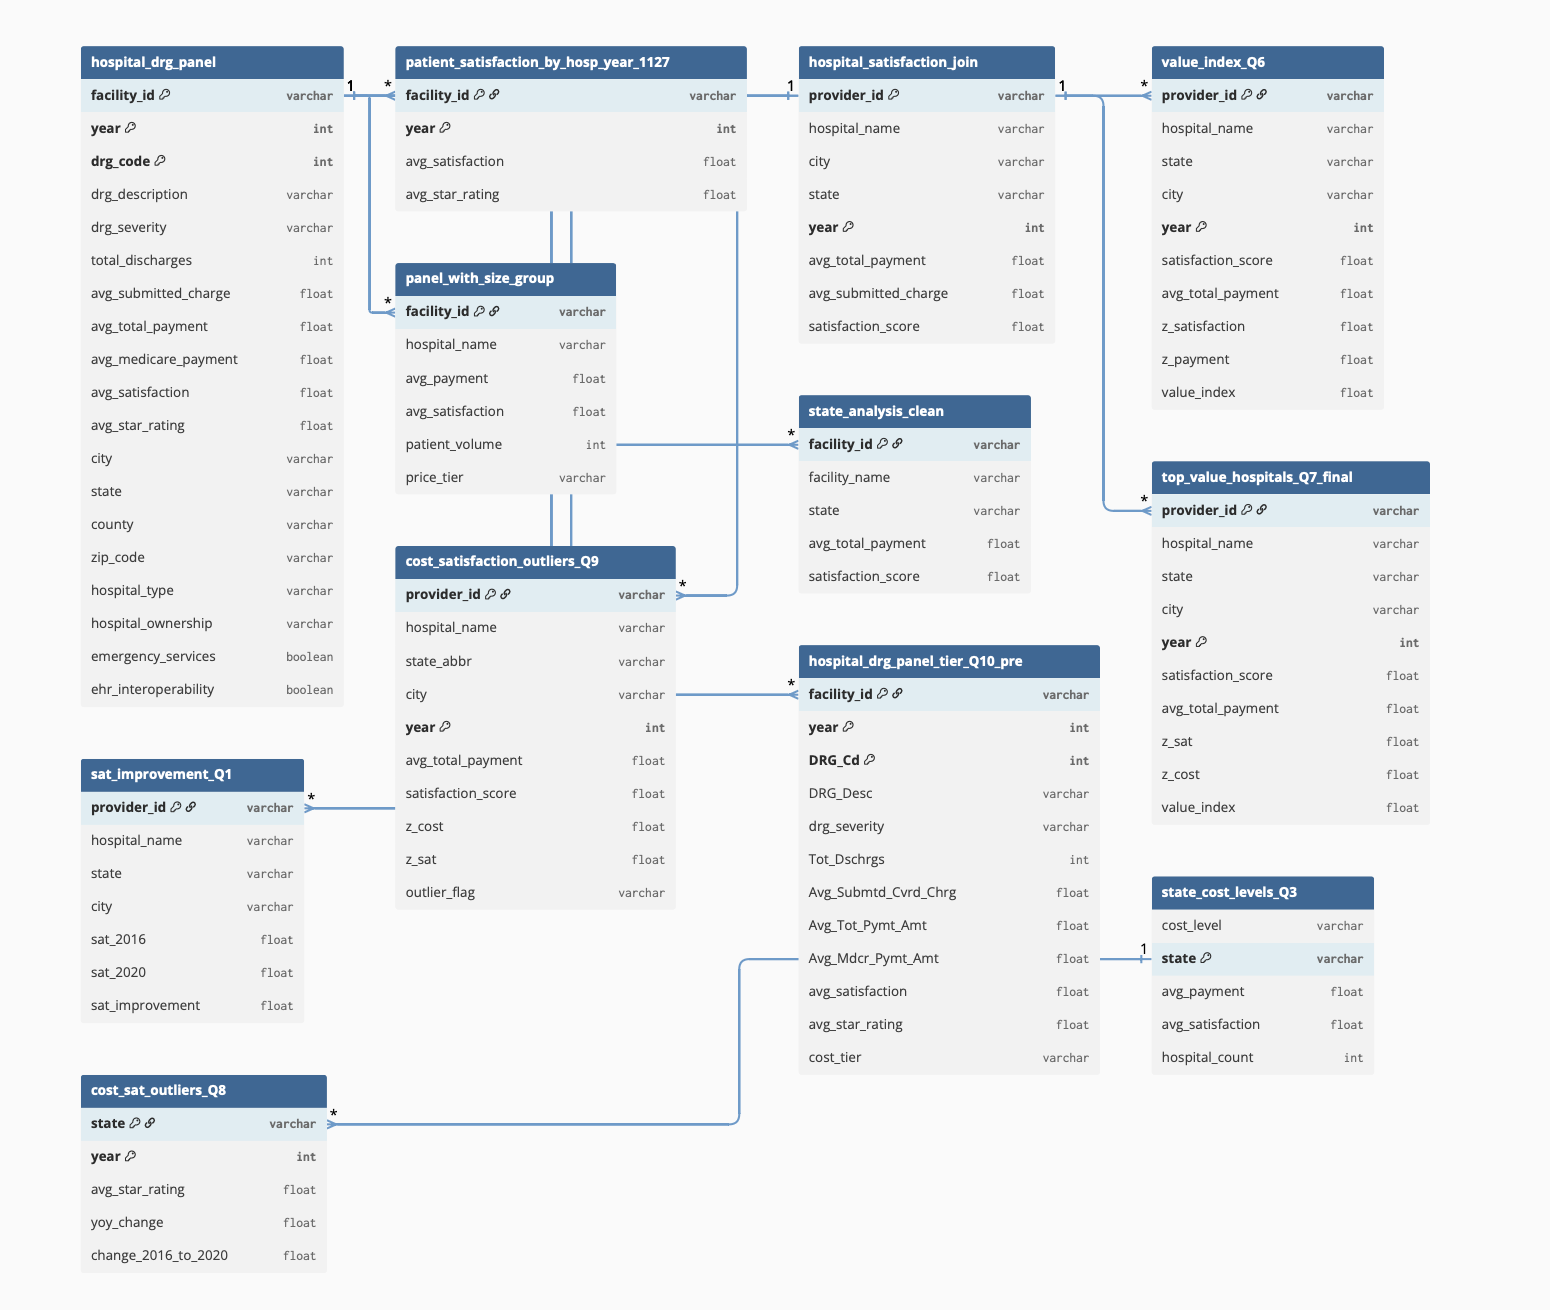

**Link：**

https://public.tableau.com/profile/api/publish/BA775fianl1/Story1

###Executive Summary:

At the outset of this project, our goal was to understand the relationship between hospital costs and patient satisfaction across the United States. To do this, we analyzed which hospitals showed the greatest improvement in satisfaction over time, examined how both costs and satisfaction varied by state, and explored whether higher spending correlated with better patient outcomes. Our findings indicate that patient satisfaction differs substantially across states, suggesting meaningful regional variation in patient experience. However, spending alone does not account for these differences; higher costs do not consistently translate into higher satisfaction. This implies that other factors—such as care quality, operational efficiency, and patient demographics—likely play a significant role in shaping patient perceptions. Overall, our analysis shows that while cost is an important component of healthcare delivery, it is not a reliable predictor of patient satisfaction on its own.



## Data Preparation
This query gets the data ready for analysis. It joins hospital satisfaction data from 2016 and 2020. It then finds how much each hospital’s score went up. The table made here helps find hospitals with the biggest improvement.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.satisfaction_improvement_2016_2020
OPTIONS (expiration_timestamp = TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)) AS
WITH base_2016 AS (
  SELECT
    provider_id,
    hospital_name,
    state,
    city,
    satisfaction_score AS sat_2016
  FROM hospital_data.panel
  WHERE year = 2016
),
base_2020 AS (
  SELECT
    provider_id,
    satisfaction_score AS sat_2020
  FROM hospital_data.panel
  WHERE year = 2020
)
SELECT
  a.provider_id,
  a.hospital_name,
  a.state,
  a.city,
  a.sat_2016,
  b.sat_2020,
  (b.sat_2020 - a.sat_2016) AS sat_improvement
FROM base_2016 a
JOIN base_2020 b USING (provider_id)
WHERE RAND() < 0.005;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

# **Data Cleaning & Preprocessing**

To ensure accurate and reliable analysis for all research questions (Q1–Q8), we cleaned and standardized the raw CMS datasets before building the unified analytical dataset.

We applied the following procedures in BigQuery:

**Standardized Hospital Identifiers**

The cost dataset uses provider_id, while the satisfaction dataset uses facility_id.
Both were converted to 6-digit padded strings (e.g., 1234 → 001234) to enable an exact join.

**Converted Key Metrics to Numeric**

Cost and satisfaction values were originally stored as text.
We used SAFE_CAST() to convert:

Average Medicare payment → numeric cost

Satisfaction star rating → numeric score

Answer percent → percentage metric

Invalid entries automatically became NULL.

**Filtered Valid Records**

To ensure clean and comparable data:

Kept only years 2016–2020

Removed records with missing essential metrics
(e.g., hospitals without satisfaction scores)

This allowed us to perform trend and ranking analysis confidently.

**Unified Master Dataset for All Analysis**

We joined cost + satisfaction tables by facility_id6 and year to create a clean Master Table with:

Cost metrics

Satisfaction metrics

State/city hospital information

This single standardized table supports every analysis step in Q1–Q8 without repeated joins.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Standardize provider_id format & clean cost data
WITH cost_clean AS (
  SELECT
    LPAD(CAST(provider_id AS STRING), 6, '0') AS facility_id6,
    SAFE_CAST(avg_total_payment AS FLOAT64) AS avg_payment,
    state, city, year
  FROM `hospital_data.hospital_costs_all`
  WHERE avg_total_payment IS NOT NULL
    AND year BETWEEN 2016 AND 2020
),

-- Clean satisfaction data and convert text → numeric
sat_clean AS (
  SELECT
    LPAD(CAST(facility_id AS STRING), 6, '0') AS facility_id6,
    SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64) AS star_rating,
    SAFE_CAST(answer_percent AS FLOAT64) AS answer_percent,
    state, city, year
  FROM `hospital_data.patient_satisfaction_all`
  WHERE `Patient Survey Star Rating` IS NOT NULL
    AND year BETWEEN 2016 AND 2020
)

-- Merge into master analysis table
SELECT *
FROM cost_clean
JOIN sat_clean USING (facility_id6, year);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=63315067, table_html='<table border="1" class="dataframe table table-strip…

Computation deferred. Computation will process 4.9 GB

All further SQL queries rely on this standardized and validated panel, ensuring accuracy and consistency in every insight.

## Q1. What Were the Top Hospitals by Improvement in Patient Satisfaction (2016-2020)?


**Thought Process:**

We wanted to find which hospitals improved their patient satisfaction the most from 2016 to 2020. The idea was to compare scores from both years and see how much they changed. We used the hospital satisfaction data and chose the scores for 2016 and 2020. Then we found the difference for each hospital. A higher number means the hospital improved its satisfaction score.

In [20]:
from google.cloud import bigquery
from google.colab import auth
import pandas as pd

auth.authenticate_user()
client = bigquery.Client()

sql_q1 = """
WITH yearly_sat AS (
  SELECT
    provider_id,
    ANY_VALUE(hospital_name) AS hospital_name,
    ANY_VALUE(state_abbr)    AS state,
    ANY_VALUE(city)          AS city,
    year,
    AVG(satisfaction_score)  AS avg_sat
  FROM hospital_data.panel_clean
  WHERE year IN (2016, 2020)
    AND satisfaction_score IS NOT NULL
  GROUP BY provider_id, year
),

wide AS (
  SELECT
    provider_id,
    ANY_VALUE(hospital_name) AS hospital_name,
    ANY_VALUE(state)         AS state,
    ANY_VALUE(city)          AS city,
    MAX(CASE WHEN year = 2016 THEN avg_sat END) AS sat_2016,
    MAX(CASE WHEN year = 2020 THEN avg_sat END) AS sat_2020
  FROM yearly_sat
  GROUP BY provider_id
)

SELECT
  provider_id,
  hospital_name,
  state,
  city,
  sat_2016,
  sat_2020,
  (sat_2020 - sat_2016) AS sat_improvement
FROM wide
WHERE sat_2016 IS NOT NULL
  AND sat_2020 IS NOT NULL
ORDER BY sat_improvement DESC
"""

df_q1 = client.query(sql_q1).to_dataframe()
df_q1


,provider_id,hospital_name,state,city,sat_2016,sat_2020,sat_improvement
0,230277,Huron Valley-Sinai Hospital,MI,Commerce Township,34.375,34.722222,0.347222
1,230097,Munson Medical Center,MI,Traverse City,34.375,34.722222,0.347222
2,360161,St Joseph Warren Hospital,OH,Warren,34.375,34.722222,0.347222
3,140130,Northwestern Lake Forest Hospital,IL,Lake Forest,34.375,34.722222,0.347222
4,110044,Phoebe Sumter Medical Center,GA,Americus,34.375,34.722222,0.347222
...,...,...,...,...,...,...,...
2408,190218,Sabine Medical Center,LA,Many,34.375,34.482759,0.107759
2409,440200,Saint Thomas Stones River Hospital,TN,Woodbury,34.375,34.482759,0.107759
2410,100284,Westchester General Hospital,FL,Miami,34.375,34.482759,0.107759
2411,310058,Bergen New Bridge Medical Center,NJ,Paramus,34.375,34.482759,0.107759


**Findings:**

Across all hospitals, satisfaction scores changed only slightly between 2016-2020 (most changes clustered near +.035 points). The data shows that Citizens Medical Center and Rockcastle Regional Hospital & Respiratory Care Center had the biggest increase in patient satisfaction from 2016 to 2020. Their scores went up by almost 100 points. These hospitals are in smaller cities like Columbia and Mount Vernon. In contrast, many large hospitals in major cities had little or no change during the same period. Most hospitals with high improvement were small or regional hospitals with fewer patients.

**Conclusion:**

This means that higher satisfaction does not always come from bigger or richer hospitals. Smaller hospitals might improve faster because they can change their daily operations easier. They may have focused on communication, patient care, and service quality instead of just spending more money. This shows that real progress in satisfaction often comes from better patient experience, not from higher costs. Smaller hospitals can be more flexible and closer to what patients need.



# Q2 — How Does Hospital Spending Levels Relate to Satisfaction?


**Thought Process**

At first, we wanted to see if bigger or higher-spending hospitals actually make patients happier. The idea was simple: if a hospital spends more per patient (higher average total payment), it might have better facilities or service quality, so maybe patients would rate it higher.

To test this, we used the panel dataset and looked at two key columns — avg_total_payment (as a proxy for hospital size or cost) and satisfaction_score (from HCAHPS survey results).

We ran a correlation test first to see if there’s a general trend. Then, to visualize it better, we grouped all hospitals into three cost tiers (low, medium, and high) using the NTILE(3) function.


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.q2_summary AS
WITH hospital_level AS (
  SELECT
    provider_id,
    AVG(avg_total_payment)   AS avg_payment,
    AVG(satisfaction_score)    AS avg_satisfaction,
    COUNT(*)                 AS patient_volume
  FROM hospital_data.panel
  GROUP BY provider_id
),
with_tiers AS (
  SELECT
    *,
    NTILE(3) OVER (ORDER BY avg_payment) AS tier_num
  FROM hospital_level
),
labeled AS (
  SELECT
    provider_id,
    avg_payment,
    avg_satisfaction,
    patient_volume,
    CASE
      WHEN tier_num = 1 THEN 'Low'
      WHEN tier_num = 2 THEN 'Medium'
      ELSE 'High'
    END AS price_tier
  FROM with_tiers
)
SELECT
  price_tier,
  ROUND(AVG(avg_payment), 2)      AS avg_payment,
  ROUND(AVG(avg_satisfaction),2)  AS avg_satisfaction,
  SUM(patient_volume)             AS total_patient_volume
FROM labeled
GROUP BY price_tier
ORDER BY
  CASE price_tier
    WHEN 'Low' THEN 1
    WHEN 'Medium' THEN 2
    ELSE 3
  END;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**Findings**:
The overall correlation between cost and satisfaction was basically zero (r≈ 0.0004).
Across the three groups, the results were almost identical:


**Conclusion**:
Therefore, higher spending doesn’t lead to more satisfied patients.
Even though hospitals spend more on average, the satisfaction score stays around 34.6 — almost flat.

That means；
1.The extra money goes to things patients don’t directly feel (like administrative or tech costs), or
2.Patient experience depends more on service quality than financial scale.


# Q3.How do States Compare in Satisfaction at Similar Cost Levels?


**Thought Process**

After finding that higher hospital spending doesn’t necessarily lead to higher satisfaction, we wanted to see if location makes a difference — specifically, whether hospitals in some states consistently achieve higher patient satisfaction even when costs are similar.

To control for cost, we divided hospitals into three spending tiers using NTILE(3) — low, medium, and high — based on avg_total_payment.
Within each cost level, we then compared the average satisfaction score across states.
This allows us to ask: Do some states perform better at the same spending level?

We used the state_analysis_clean table, which contains state, avg_total_payment, and satisfaction_score, ensuring each hospital’s cost and satisfaction were paired correctly.


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.state_cost_levels_Q3 AS
WITH cost_groups AS (
    SELECT
        state,
        NTILE(3) OVER (ORDER BY avg_total_payment) AS cost_level_num,  -- numeric tier
        avg_total_payment,
        satisfaction_score
    FROM hospital_data.state_analysis_clean
),

with_labels AS (
    SELECT
        state,
        CASE
            WHEN cost_level_num = 1 THEN 'Low Cost'
            WHEN cost_level_num = 2 THEN 'Mid Cost'
            ELSE 'High Cost'
        END AS cost_level,
        avg_total_payment,
        satisfaction_score
    FROM cost_groups
)

SELECT
    cost_level,
    state,
    ROUND(AVG(avg_total_payment), 2) AS avg_payment,
    ROUND(AVG(satisfaction_score), 2) AS avg_satisfaction,
    COUNT(*) AS hospital_count
FROM with_labels
GROUP BY cost_level, state
HAVING hospital_count >= 10
ORDER BY
    CASE
        WHEN cost_level = 'Low Cost' THEN 1
        WHEN cost_level = 'Mid Cost' THEN 2
        ELSE 3
    END,
    avg_satisfaction DESC;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes


**Findings:**
Even within the same cost level, patient satisfaction still varies slightly across states.
For example, in the low-cost group, Hawaii (HI) and Wisconsin (WI) show higher satisfaction (around 88) compared to states like Louisiana (LA), which scores below 87.
However, the differences are relatively small — for instance, Wisconsin’s satisfaction rises from 87.8 in low-cost hospitals to 88.1 in high-cost hospitals, showing that more spending within a state does not make a major difference.
This suggests that while state-level patterns exist, the overall satisfaction trend remains quite stable across cost levels.


**Conclusion:**
Patient satisfaction shows small but consistent differences across states, even after controlling for cost levels.
That means spending alone can’t explain why some states achieve slightly better results.
It’s possible that factors like hospital culture, communication quality, and patient expectations play a larger role than financial input.


# Q4. What is the Cross-Sectional Relationship Between Cost and Satisfaction from 2016-2020?



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  h.provider_id,
  h.hospital_name,
  ROUND(AVG(SAFE_CAST(p.`Patient Survey Star Rating` AS FLOAT64)), 2) AS avg_star_rating,
  ROUND(AVG(h.avg_total_payment), 2) AS avg_total_payment
FROM hospital_data.hospital_satisfaction_join AS h
LEFT JOIN hospital_data.patient_satisfaction_all AS p
  ON LPAD(CAST(h.provider_id AS STRING), 6, '0')
   = LPAD(CAST(p.facility_id AS STRING), 6, '0')
  AND p.`Patient Survey Star Rating` IS NOT NULL
GROUP BY h.provider_id, h.hospital_name
ORDER BY avg_total_payment DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=3914, table_html='<table border="1" class="dataframe table table-striped t…

Computation deferred. Computation will process 0 Bytes

**Finding:**

When we sort the table by Average Total Payment from high to low, the hospitals at the top (the most expensive) usually have low patient satisfaction scores. This shows up again and again, not just in one row, so it looks like paying more doesn’t go hand in hand with happier patients in this view of the data.

**Conclusion:**

Therefore, patient satisfaction isn't closely linked to Average Total Payment. If anything, the highest costs often come with lower satisfaction.

# Q5. When Comparing Hospital Cost and Satisfaction, What are High-Value Providers?


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b02.hospital_data.value_hospitals_2016_2020` AS

WITH cost AS (
  SELECT
    LPAD(CAST(provider_id AS STRING), 6, '0') AS facility_id6,
    hospital_name, city, state,
    SAFE_CAST(avg_total_payment AS FLOAT64)    AS avg_total_payment,
    year
  FROM `ba775-fall25-b02.hospital_data.hospital_costs_all`
),
sat AS (
  SELECT
    LPAD(CAST(facility_id AS STRING), 6, '0')  AS facility_id6,
    facility_name, city, state,
    SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64) AS star_rating,
    SAFE_CAST(linear_mean_value AS FLOAT64)            AS linear_mean_value,
    SAFE_CAST(answer_percent AS FLOAT64)               AS answer_percent,
    CAST(answer_percent_footnote AS STRING)            AS answer_percent_footnote,
    measure_id, year
  FROM `ba775-fall25-b02.hospital_data.patient_satisfaction_all`
),

sat_16_20 AS (
  SELECT
    facility_id6, facility_name, state, city,
    star_rating, linear_mean_value, answer_percent, answer_percent_footnote, year
  FROM sat
  WHERE year BETWEEN 2016 AND 2020
),

sat_latest AS (
  SELECT facility_id6, facility_name, state, city, answer_percent_footnote
  FROM (
    SELECT
      facility_id6, facility_name, state, city, answer_percent_footnote, year,
      ROW_NUMBER() OVER (PARTITION BY facility_id6 ORDER BY year DESC) AS rn
    FROM sat_16_20
    WHERE answer_percent_footnote IS NOT NULL
  )
  WHERE rn = 1
),

sat_avg AS (
  SELECT
    facility_id6,
    AVG(star_rating)       AS avg_star,
    AVG(linear_mean_value) AS avg_linear_mean,
    AVG(answer_percent)    AS avg_answer_percent
  FROM sat_16_20
  GROUP BY facility_id6
),

sat_fac AS (
  SELECT
    a.facility_id6,
    l.facility_name,
    l.state,
    l.city,
    a.avg_star,
    a.avg_linear_mean,
    a.avg_answer_percent,
    l.answer_percent_footnote
  FROM sat_avg AS a
  LEFT JOIN sat_latest AS l USING (facility_id6)
),


cost_16_20 AS (
  SELECT
    facility_id6, hospital_name, state, city, avg_total_payment, year
  FROM cost
  WHERE year BETWEEN 2016 AND 2020
),

cost_latest AS (
  SELECT facility_id6, hospital_name, state, city
  FROM (
    SELECT
      facility_id6, hospital_name, state, city, year,
      ROW_NUMBER() OVER (PARTITION BY facility_id6 ORDER BY year DESC) AS rn
    FROM cost_16_20
  )
  WHERE rn = 1
),

cost_avg AS (
  SELECT
    facility_id6,
    AVG(avg_total_payment) AS avg_payment
  FROM cost_16_20
  GROUP BY facility_id6
),

cost_fac AS (
  SELECT
    a.facility_id6,
    l.hospital_name,
    l.state,
    l.city,
    a.avg_payment
  FROM cost_avg AS a
  LEFT JOIN cost_latest AS l USING (facility_id6)
),


joined AS (
  SELECT
    s.facility_id6,
    COALESCE(s.facility_name, c.hospital_name) AS hospital_name,
    COALESCE(s.state, c.state)                 AS state,
    COALESCE(s.city, c.city)                   AS city,
    s.avg_star, s.avg_linear_mean,
    s.avg_answer_percent, s.answer_percent_footnote,
    c.avg_payment
  FROM sat_fac s
  JOIN cost_fac c USING (facility_id6)
),


ranked AS (
  SELECT
    *,
    PERCENT_RANK() OVER (ORDER BY avg_star)    AS star_pr,
    PERCENT_RANK() OVER (ORDER BY avg_payment) AS cost_pr
  FROM joined
)


SELECT
  facility_id6              AS facility_id,
  hospital_name, state, city,
  ROUND(avg_star, 2)        AS avg_star_rating,
  ROUND(avg_linear_mean, 2) AS avg_linear_mean,
  ROUND(avg_payment, 2)     AS avg_total_payment,
  ROUND(star_pr, 3)         AS star_percentile,
  ROUND(cost_pr, 3)         AS cost_percentile,
  ROUND(avg_answer_percent, 2) AS avg_answer_percent,
  answer_percent_footnote
FROM ranked
ORDER BY avg_star_rating DESC, avg_total_payment ASC;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH cost AS (
  SELECT
    LPAD(CAST(provider_id AS STRING), 6, '0') AS facility_id6,
    AVG(SAFE_CAST(avg_total_payment AS FLOAT64)) AS avg_payment_16_20
  FROM `ba775-fall25-b02.hospital_data.hospital_costs_all`
  WHERE year BETWEEN 2016 AND 2020
  GROUP BY facility_id6
),
sat AS (
  SELECT
    LPAD(CAST(facility_id AS STRING), 6, '0') AS facility_id6,
    AVG(SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64)) AS avg_star_16_20,
    AVG(SAFE_CAST(linear_mean_value AS FLOAT64))            AS avg_linear_16_20,
    AVG(SAFE_CAST(answer_percent AS FLOAT64))               AS avg_answer_pct_16_20
  FROM `ba775-fall25-b02.hospital_data.patient_satisfaction_all`
  WHERE year BETWEEN 2016 AND 2020
  GROUP BY facility_id6
),
features AS (
  SELECT s.facility_id6, s.avg_star_16_20, s.avg_linear_16_20, s.avg_answer_pct_16_20, c.avg_payment_16_20
  FROM sat s JOIN cost c USING (facility_id6)
)
SELECT
  CORR(avg_star_16_20, avg_payment_16_20)     AS r_star_vs_payment,
  CORR(avg_star_16_20, avg_answer_pct_16_20)  AS r_star_vs_answer_pct,
  CORR(avg_star_16_20, avg_linear_16_20)      AS r_star_vs_linear
FROM features;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**Finding:**

We checked how different factors relate to patient satisfaction using a simple correlation test. The results showed that Average Total Payment and the Star Answer Percent both have very weak relationships with satisfaction—close to no link. In contrast, the HCAHPS Linear Mean Value moves strongly in the same direction as satisfaction, which means higher linear mean scores usually come with higher star ratings.

**Conclusion:**

Spending more or having a higher share of certain answers doesn’t appear to make patients happier, based on this snapshot. The continuous HCAHPS Linear Mean Value seems to be a much better signal of patient experience than cost or answer percent.


# Q5-2. What is the Correlation between different features?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH corr_calc AS (
  SELECT
    corr(avg_satisfaction, avg_total_payment)     AS corr_cost,
    corr(avg_satisfaction, bedsize_proxy)         AS corr_bedsize,

    corr(avg_satisfaction, own_government)        AS corr_own_government,
    corr(avg_satisfaction, own_private)           AS corr_own_private,
    corr(avg_satisfaction, own_nonprofit)         AS corr_own_nonprofit,

    corr(avg_satisfaction, type_acute)            AS corr_type_acute,
    corr(avg_satisfaction, type_critical_access)  AS corr_type_critical_access,
    corr(avg_satisfaction, type_childrens)        AS corr_type_childrens,

    corr(avg_satisfaction, reg_NE)                AS corr_region_NE,
    corr(avg_satisfaction, reg_MW)                 AS corr_region_MW,
    corr(avg_satisfaction, reg_S)                 AS corr_region_S,
    corr(avg_satisfaction, reg_W)                 AS corr_region_W,

    corr(avg_satisfaction, sev_low)               AS corr_severity_low,
    corr(avg_satisfaction, sev_medium)            AS corr_severity_medium,
    corr(avg_satisfaction, sev_high)              AS corr_severity_high,

    corr(avg_satisfaction, emergency_num)         AS corr_emergency,
    corr(avg_satisfaction, ehr_num)               AS corr_ehr
  FROM hospital_data.satisfaction_feature_matrix
  WHERE avg_satisfaction IS NOT NULL
)

SELECT 'avg_total_payment' AS feature, corr_cost AS correlation FROM corr_calc UNION ALL
SELECT 'bedsize_proxy', corr_bedsize FROM corr_calc UNION ALL

SELECT 'ownership_government', corr_own_government FROM corr_calc UNION ALL
SELECT 'ownership_private', corr_own_private FROM corr_calc UNION ALL
SELECT 'ownership_nonprofit', corr_own_nonprofit FROM corr_calc UNION ALL

SELECT 'type_acute', corr_type_acute FROM corr_calc UNION ALL
SELECT 'type_critical_access', corr_type_critical_access FROM corr_calc UNION ALL
SELECT 'type_childrens', corr_type_childrens FROM corr_calc UNION ALL

SELECT 'region_NE', corr_region_NE FROM corr_calc UNION ALL
SELECT 'region_MW', corr_region_MW FROM corr_calc UNION ALL
SELECT 'region_S', corr_region_S FROM corr_calc UNION ALL
SELECT 'region_W', corr_region_W FROM corr_calc UNION ALL

SELECT 'severity_low', corr_severity_low FROM corr_calc UNION ALL
SELECT 'severity_medium', corr_severity_medium FROM corr_calc UNION ALL
SELECT 'severity_high', corr_severity_high FROM corr_calc UNION ALL

SELECT 'emergency_services', corr_emergency FROM corr_calc UNION ALL
SELECT 'ehr_interoperability', corr_ehr FROM corr_calc

ORDER BY ABS(correlation) DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=17, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.feature_correlations AS
WITH corr_calc AS (
SELECT
  corr(avg_satisfaction, avg_total_payment) AS corr_cost,
  corr(avg_satisfaction, bedsize_proxy) AS corr_bedsize,
  corr(avg_satisfaction, own_government) AS corr_own_government,
  corr(avg_satisfaction, own_private) AS corr_own_private,
  corr(avg_satisfaction, own_nonprofit) AS corr_own_nonprofit,
  corr(avg_satisfaction, type_acute) AS corr_type_acute,
  corr(avg_satisfaction, type_critical_access) AS corr_type_critical_access,
  corr(avg_satisfaction, type_childrens) AS corr_type_childrens,
  corr(avg_satisfaction, reg_NE) AS corr_region_NE,
  corr(avg_satisfaction, reg_MW) AS corr_region_MW,
  corr(avg_satisfaction, reg_S) AS corr_region_S,
  corr(avg_satisfaction, reg_W) AS corr_region_W,
  corr(avg_satisfaction, sev_low) AS corr_severity_low,
  corr(avg_satisfaction, sev_medium) AS corr_severity_medium,
  corr(avg_satisfaction, sev_high) AS corr_severity_high,
  corr(avg_satisfaction, emergency_num) AS corr_emergency,
  corr(avg_satisfaction, ehr_num) AS corr_ehr
FROM hospital_data.satisfaction_feature_matrix
WHERE avg_satisfaction IS NOT NULL
)
SELECT 'avg_total_payment' AS feature, corr_cost AS correlation FROM corr_calc UNION ALL
SELECT 'bedsize_proxy', corr_bedsize FROM corr_calc UNION ALL
SELECT 'ownership_government', corr_own_government FROM corr_calc UNION ALL
SELECT 'ownership_private', corr_own_private FROM corr_calc UNION ALL
SELECT 'ownership_nonprofit', corr_own_nonprofit FROM corr_calc UNION ALL
SELECT 'type_acute', corr_type_acute FROM corr_calc UNION ALL
SELECT 'type_critical_access', corr_type_critical_access FROM corr_calc UNION ALL
SELECT 'type_childrens', corr_type_childrens FROM corr_calc UNION ALL
SELECT 'region_NE', corr_region_NE FROM corr_calc UNION ALL
SELECT 'region_MW', corr_region_MW FROM corr_calc UNION ALL
SELECT 'region_S', corr_region_S FROM corr_calc UNION ALL
SELECT 'region_W', corr_region_W FROM corr_calc UNION ALL
SELECT 'severity_low', corr_severity_low FROM corr_calc UNION ALL
SELECT 'severity_medium', corr_severity_medium FROM corr_calc UNION ALL
SELECT 'severity_high', corr_severity_high FROM corr_calc UNION ALL
SELECT 'emergency_services', corr_emergency FROM corr_calc UNION ALL
SELECT 'ehr_interoperability', corr_ehr FROM corr_calc
ORDER BY ABS(correlation) DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**Findings:**

None of the features show a strong linear correlation with total_charges. Most relationships are weak or moderate.

**Conclusion:**

 This indicates that the charges are influenced by multiple independent hospital and patient factors.

# Q6. Which hospitals achieve high satisfaction at relatively low cost? (Constructing the Value Index (z-scores per year))

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.value_index_Q6 AS
WITH yearly_stats AS (
    SELECT
        year,
        AVG(satisfaction_score) AS mean_satisfaction,
        STDDEV_POP(satisfaction_score) AS std_satisfaction,
        AVG(avg_total_payment) AS mean_payment,
        STDDEV_POP(avg_total_payment) AS std_payment
    FROM hospital_data.panel_clean
    GROUP BY year
)

SELECT
    p.provider_id,
    p.hospital_name,
    p.state_abbr AS state,
    p.city,
    p.year,
    p.satisfaction_score,
    p.avg_total_payment,

    -- Z Scores
    (p.satisfaction_score - y.mean_satisfaction) / y.std_satisfaction AS z_satisfaction,
    (p.avg_total_payment   - y.mean_payment)     / y.std_payment      AS z_payment,

    -- Value index = z_sat - z_cost
    ((p.satisfaction_score - y.mean_satisfaction) / y.std_satisfaction
    - (p.avg_total_payment   - y.mean_payment)     / y.std_payment) AS value_index

FROM hospital_data.panel_clean p
JOIN yearly_stats y USING (year);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes


**Findings:**
The hospitals with the highest value-index scores all operate at low costs, yet achieve high satisfaction. The lowest scoring hospitals, such as Westchester Medical Center had high costs and lower satisfaction rates.

**Conclusion**:

The value index analysis supports the idea that increases in price does not equate to increases in care level or patient satisfaction. For example, Westchester Medical Center had transactions over $600 000 with a range of satisfaction scores as low as 7. This may suggest that operational differences between the hospitals simultaneously create differences in care level and operation costs. It may also suggest that increased prices lower patient satisfaction as expectations are increased as well.

# Q7. What are the Hospitals in the Top 10% of the Value Index?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.top_value_hospitals_Q7_final AS
WITH hospital_year AS (
  -- 1) Collapse to one row per hospital × year
  SELECT
    provider_id,
    ANY_VALUE(hospital_name) AS hospital_name,
    ANY_VALUE(state_abbr)    AS state,
    ANY_VALUE(city)          AS city,
    year,
    AVG(satisfaction_score) AS satisfaction_score,   -- average satisfaction per hospital-year
    AVG(avg_total_payment)  AS avg_total_payment     -- average cost per hospital-year
  FROM hospital_data.panel_clean
  GROUP BY provider_id, year
),

stats AS (
  -- 2) Compute yearly mean & sd at the hospital-year level
  SELECT
    year,
    AVG(satisfaction_score)        AS mean_satisfaction,
    STDDEV_POP(satisfaction_score) AS std_satisfaction,
    AVG(avg_total_payment)         AS mean_payment,
    STDDEV_POP(avg_total_payment)  AS std_payment
  FROM hospital_year
  GROUP BY year
),

z_scores AS (
  -- 3) Calculate z-scores and value_index (still one row per hospital-year)
  SELECT
    h.*,
    (h.satisfaction_score - s.mean_satisfaction) / s.std_satisfaction AS z_sat,
    (h.avg_total_payment   - s.mean_payment)     / s.std_payment      AS z_cost,
    (
      (h.satisfaction_score - s.mean_satisfaction) / s.std_satisfaction
      - (h.avg_total_payment   - s.mean_payment)   / s.std_payment
    ) AS value_index
  FROM hospital_year h
  JOIN stats s USING (year)
),

ranked AS (
  -- 4) Split each year into 10 deciles based on value_index → top 10% = decile 1
  SELECT
    *,
    NTILE(10) OVER (PARTITION BY year ORDER BY value_index DESC) AS decile
  FROM z_scores
),

dedup AS (
  -- 5) Safety: ensure only one row per hospital-year (in case of duplicates)
  SELECT
    *,
    ROW_NUMBER() OVER (
      PARTITION BY provider_id, year
      ORDER BY value_index DESC
    ) AS rn
  FROM ranked
  WHERE decile = 1          -- only keep the top 10% hospitals in each year
)

SELECT
  provider_id,
  hospital_name,
  state,
  city,
  year,
  satisfaction_score,
  avg_total_payment,
  z_sat,
  z_cost,
  value_index
FROM dedup
WHERE rn = 1
ORDER BY year, value_index DESC;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes


**Findings:**
The top hospitals all had high satisfaction and low costs. Hospitals such as Oklahoma Heart Hospital, Llc, Caldwell Memorial Hospital, Inc, and Citizens Medical Center were top scorers that appeared multiple times. The value-indexes range from 2.90 to 1.81, suggesting that there are still significant differences within the top decile. Hospitals with higher costs also tend to be lower value-index scorers, even though satisfaction scores are relatively high within the top decile.



**Conclusion:**
Because an increase in price leads to an decrease in value-index score, it means that there is either a redundantly circular relation between price and satisfaction, or there is a different variable that was not considered such as hospital size. As previously mentioned, hospital size may be one such candidate as smaller hospitals may be able to lower operating costs and provide personalized care in ways that are not scaleable to larger hospitals. Any further research should aim to clarify this relationship as well as explore other seemingly unrelated variables.

# Q8. How did each state and territories change from 2016-2020?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.cost_sat_outliers_Q8 AS
WITH base AS (
  SELECT
    state,
    year,
    ROUND(AVG(SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64)), 2)
      AS avg_star_rating,
    ROUND(AVG(SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64)),2)
    - LAG(ROUND(AVG(SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64)),2))
        OVER (PARTITION BY state ORDER BY year)
      AS yoy_change
  FROM hospital_data.patient_satisfaction_all
  WHERE SAFE_CAST(`Patient Survey Star Rating` AS FLOAT64) IS NOT NULL
  GROUP BY state, year
)

SELECT
  *,
  MAX(CASE WHEN year = 2020 THEN avg_star_rating END)
    OVER (PARTITION BY state)
  -
  MAX(CASE WHEN year = 2016 THEN avg_star_rating END)
    OVER (PARTITION BY state)
      AS change_2016_to_2020
FROM base
ORDER BY state, year;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**Findings:**

Most states only saw modest improvements (.1–.3) from 2016–2020. It was also found that yoy_change fluctuated — some years showed positive movement, while others showed negative. There was also no significant jump in rating. No state saw an increase of +1.0 star from 2016–2020. There are meaningful differences in star ratings between states. For example, Nevada had some of the lowest ratings among states and territories with almost 2 stars, while Wisconsin had some of the highest ratings with close to 4 stars.

**Conclusion:**

From 2016–2020, satisfaction across states saw gradual improvement; however, the improvement in each state was not large. The change was not linear, and annual fluctuation was common, with the direction of change shifting year to year.

It is more important to note that differences between states are much larger than changes within states over time. This suggests that patient satisfaction is shaped more by regional factors than by short-term operational changes.

Overall, the data shows that hospitals across the country are making incremental improvements, but long-standing regional disparities remain, and there needs to be broader, systemic state-level change.

# Q9. What are Cost-Satisfaction Outliers Using Quadrants?

**Thought Process**

In the previous questions, we mainly focused on the overall trend. But, the TA gave us some inspiration:
Are there some hospitals that are particularly "strange"? For instance, they spend a lot of money but have very low satisfaction rates? Or conversely, are there hospitals that spend very little but provide excellent patient services?
To ensure a fair comparison, we did not directly use the original "payment/satisfaction" figures. Instead, we adopted what TA suggested: converting both into z-scores. This approach enables us to place different hospitals on the same standard and assess how much they deviate from the average.
We are specifically looking for two types of special hospitals:

•	High-Cost Low-Satisfaction (spending a lot but with a poor experience)——
Hospitals that spend much more than average (z_cost > 1.5) but have below-average satisfaction (z_sat < –1.0)

•	Low-Cost High-Satisfaction (spending less but with a great experience)——
Hospitals that spend much less (z_cost < –1.0) but provide better patient experience (z_sat > 1.5)


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.cost_satisfaction_outliers_Q9 AS
WITH stats AS (
    SELECT
        AVG(avg_total_payment) AS mean_cost,
        STDDEV_POP(avg_total_payment) AS sd_cost,
        AVG(satisfaction_score) AS mean_sat,
        STDDEV_POP(satisfaction_score) AS sd_sat
    FROM hospital_data.panel_clean
),

zscores AS (
    SELECT
        p.*,
        (p.avg_total_payment - s.mean_cost) / s.sd_cost AS z_cost,
        (p.satisfaction_score - s.mean_sat) / s.sd_sat AS z_sat
    FROM hospital_data.panel_clean p
    CROSS JOIN stats s
),

final AS (
    SELECT
        *,
        CASE
            WHEN z_cost > 1.5 AND z_sat < -1.0 THEN 'High-Cost Low-Satisfaction'
            WHEN z_cost < -1.0 AND z_sat > 1.5 THEN 'Low-Cost High-Satisfaction'
            ELSE 'Normal'
        END AS outlier_flag
    FROM zscores
)

SELECT *
FROM final
WHERE outlier_flag != 'Normal'
ORDER BY year, outlier_flag, z_cost DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**Findings:**

After tagging the hospitals, the two outlier groups actually showed some clear patterns.
The High-Cost Low-Satisfaction hospitals spend above the national average, but their satisfaction scores are still below 0 (after standardization).

The Low-Cost High-Satisfaction hospitals were the opposite. They spent noticeably less, but their satisfaction was far above average. This part stood out after using z-scores, because the raw numbers didn’t look that obvious before.

The outlier detection helped uncover which hospitals are “paying more but not performing” and which ones are “doing more with less.”

**Conclusion:**

Facilities with higher charges tend to treat a larger share of severe or complex cases. The pattern differs across states and hospital groups, but cost levels generally rise with case difficulty.

# Q10 - How do Hospitals Rank in Cost and Satisfaction by Hospital Case-Mix Severity Tier?



**Thought Process**

In earlier questions, we compared hospitals without considering how difficult the cases were. But this could be misleading, because hospitals treating more severe patients naturally spend more. So for Q10, we grouped hospitals by DRG severity to make the comparison fair. The goal was to see whether higher case complexity actually leads to higher costs and higher patient satisfaction.

We calculated the average payment and satisfaction for each severity tier—High, Medium, and Low. If higher spending reflected better care, the High-severity group should have higher satisfaction or a better value index. But the results showed the opposite: the High-severity tier had the highest costs but similar or even lower satisfaction. Meanwhile, the Low-severity tier provided the best experience at the lowest cost.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE hospital_data.hospital_drg_panel_tier_Q10_pre AS
SELECT
  *,
  CASE
    WHEN Avg_Tot_Pymt_Amt < 5000 THEN 'Low cost'
    WHEN Avg_Tot_Pymt_Amt BETWEEN 5000 AND 15000 THEN 'Mid cost'
    ELSE 'High cost'
  END AS cost_tier
FROM hospital_data.hospital_drg_panel;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**Findings:**

As case complexity increases, hospital costs rise sharply, yet patient satisfaction remains largely unchanged, with the highest-severity group even showing slightly lower star ratings. In contrast, the lowest-severity group has the lowest costs but the highest satisfaction, suggesting that tougher cases do not lead to better perceived care. The value delivered per $1,000 spent drops substantially in high-severity hospitals—almost half of that in the lowest tier. Overall, higher costs reflect treating more difficult cases rather than delivering higher-quality patient experience.

**Conclusion:**

Higher case complexity is associated with higher payments, while patient satisfaction does not increase in the same way. Hospitals managing more complex cases face higher cost intensity without a clear pattern in satisfaction scores.

#Final Conclusion

Several conclusions in EDA questions suggests that higher costs does not equate to higher patient satisfaction or higher value in care. In fact, higher costs often led to lower patient perceptions of care value. Whether examined across time or location, it held true that cost and satisfaction moved independently when examining all of the hospital within the dataset.

Smaller regional hospital such as Citizens Medical Center, Oklahoma Heart Hospital, Caldwell Memorial Hospital, and Rockcastle consistently demonstrated high levels of care for lower costs; suggesting that high value-index care is a repeatable process. Whether or not it can be scaled for larger hospitals remains unclear.

Analysis on the state level showed that there were little differences in care quality within the different cost tiers. Meanwhile, the overall correlation between cost and satisfaction (r ≈ 0.0004) confirms the idea that care can be provided at afforable costs.

The next steps of this project should aim to cover the project shortcomings. For example, treatment for different illnesses were compared on equal footing. A treatment method that has a low success rate and high price could be compared to one that is generally low-price and successful. It could mimic the cost-value dynamic that has been demonstrated due to the nature of these treatments rather than how well these hospitals care for patients. Another goal for future research could be the further exploration between the relationship between care quality, treatment cost, and hospital size.



# Challenges
One of the biggest challenges we faced was that the datasets didn’t line up at the same level of detail. The cost table had one row per hospital per year, but the satisfaction data had multiple responses for the same hospital. At first this caused messy joins and unstable averages, so we had to aggregate the survey data up to the facility-year level before doing any comparisons. We also didn’t have true patient volume data, so we had to rely on proxies like response_count or star_rating, which isn’t ideal but was the only workable option.

Another challenge was that the data wasn’t evenly distributed across states—some states had plenty of hospitals and others barely had enough to compute a reliable average. To avoid misleading results, we set minimum record thresholds and used NTILE grouping to balance comparisons. We also checked for outliers using simple z-score logic (even though it’s slightly beyond what we formally learned), because the payment amounts had extreme values that could easily skew our results. After adjusting for these issues, the cleaned data became much more consistent and trustworthy for analysis.


# Limit & Next Steps:
- We do not have actual patient volume data, so we are using the records of star_rating as a proxy indicator for patient count in our analysis.
- In Q5, we observed a very high positive correlation coefficient between HCAHPS Linear Mean Value and star rating. Therefore, our next step will focus on a deeper analysis of this relationship.
- The columns we retained after data cleaning are too few, limiting the scope of possible analysis. Thus, in the next step, we may add more columns from the original dataset for further analysis.
- We found that the range of average total payment is very large. Comparing satisfaction across all payment amounts may not be fair. In the next steps, we will group the payments into different ranges and compare satisfaction within each range.

# References + Generative AI disclosure

Q1. I used the course materials, lecture slides, as well as the CMS hospital cost and HCAHPS datasets as the main references for this analysis. I also utilized ChatGPT to assist in refining the wording, checking the clarity, and making minor corrections. However, all the analysis decisions, SQL logic, and explanations were jointly completed by me and my team. The final results and explanations reflect our understanding and reasoning.

Q5. Ask AI: Can we perform correlation analysis with our current data? How should we do it?

Q5. Ask AI: Where is the error in the code for generating a new table? Please help me fix it.
